# DDPG

For ReLAx & Mujoco installation see:
https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding DDPG:
- DDPG paper: https://arxiv.org/abs/1509.02971
- DDPG description: https://spinningup.openai.com/en/latest/algorithms/ddpg.html

!Note: For examining trained actor you may just load trained policies from \trained_models directory.
To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/relax_ddpg_example

In [60]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import DDPG, Random
from relax.rl.critics import CDQN

from relax.zoo.policies import DeterministicMLP
from relax.zoo.critics import ContQMLP

from relax.schedules import PiecewiseSchedule, LinearSchedule, CombinedSchedule
from relax.exploration import OrnsteinUhlenbeck

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

from relax.gym.utils import visualize_actor

# Constructing Actor's deterministic policy

DDPG is a continuous control algorithm and its policy does not have any
stochasticity inside itself. So policy is just a neural network mapping observation space 
with a shape (BATCH_SIZE, *obs.shape) to a continuous action space (BATCH_SIZE, ACS_DIM).

Therefore any custom user defined networks meeting this requirements should work well 
with DDPG actor

Preferably action space should have some finite range of values, e.g [-1, 1].

So let's examine the default implementation of deterministic policy offered by ReLAx:

In [2]:
print(getsource(DeterministicMLP))

class DeterministicMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, 
                 hidden1=400, hidden2=300,
                 activation=nn.ReLU(),
                 out_activation=nn.Identity(),
                 acs_scale=1.0, acs_bias=0.0):
        
        super(DeterministicMLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(obs_dim, hidden1))
        layers.append(activation)
        layers.append(nn.Linear(hidden1, hidden2))
        layers.append(activation)
        layers.append(nn.Linear(hidden2, acs_dim))
        layers.append(out_activation)
        self.layers = nn.Sequential(*layers)
        self.acs_dim = acs_dim
        self.acs_scale = acs_scale
        self.acs_bias = acs_bias
        
    def forward(self, obs):
        flat_obs = torch.flatten(obs, start_dim=1)
        acs = self.layers(flat_obs)
        return acs * self.acs_scale + self.acs_bias



# Constructing Continuous Deep Q-Network Critic

Actor's deterministic policy is trained in pair with critic network which approximates Q-Function for a given observation-action pair. That means that critic net is taking as an input an observations batch with a shape of (BATCH_SIZE, *obs.shape) and a batch of corresponding actions with a shape (BATCH_SIZE, ACS_DIM) and outputting Q-Values batch with a shape (BATCH_SIZE, 1).

Therefore any custom user defined networks meeting this requirements should work well with CDQN critic

So let's examine the default implementation of Continuous Deep Q-Network Critic offered by ReLAx:

In [3]:
print(getsource(ContQMLP))

class ContQMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, 
                 hidden1=400, hidden2=300,
                 activation=nn.ReLU(),
                 out_activation=nn.Identity(),
                 init_w=3e-3):
        
        super(ContQMLP, self).__init__()
        
        self.fc1 = nn.Linear(obs_dim+acs_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.activation = activation
        self.out_activation = out_activation
        self.acs_dim = acs_dim
        
    def forward(self, obs, acs):
        
        out = self.fc1(
            torch.cat(
                [torch.flatten(obs, start_dim=1), acs], 
                dim=-1
            )
        )
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        out = self.out_activation(out)
        
        return out



# Set Up Exploration

DDPG uses Ornstein - Uhlenbeck random process as exploration. The key feature of Ornstein - Uhlenbeck random process is the fact that it produces temporarily correlated random noise. It is then added to actor's deterministic actions in order to drive exploration. Noise magnitude is typically annealed over the course of training. In some sense the overall logic of altering actor's actions randomly resembles E-Greedy exploration for DQN.

Lets plot some noise generated by Ornstein - Uhlenbeck random process to see how it works:

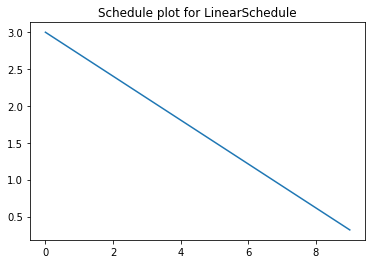

In [4]:
# toy annealed sigma schedule
sigma_schedule = LinearSchedule(3., 0.02, 10)
sigma_schedule.plot(10)

In [5]:
# create toy exploration for plots
test_exploration = OrnsteinUhlenbeck(
    theta=0.15, # Speed of convergence to mu
    mu=10, # Point to converge to
    sigma=sigma_schedule, # Noise magnitude
    dt=1e-2,
    x0=None, # Initial point to start with ([0] * dim f None)
    dim=2 # Action dimensions (2 for easy plotting)
)

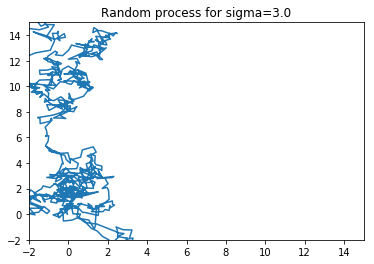

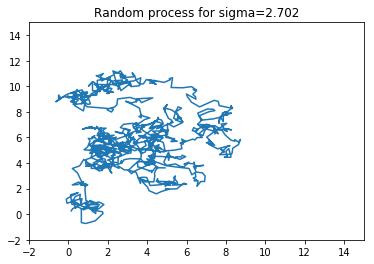

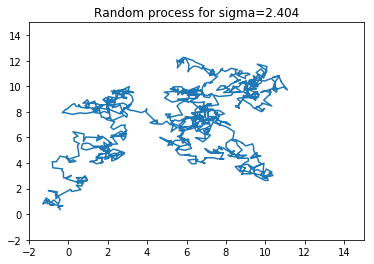

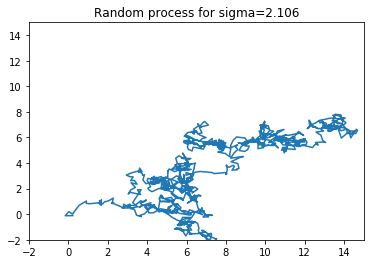

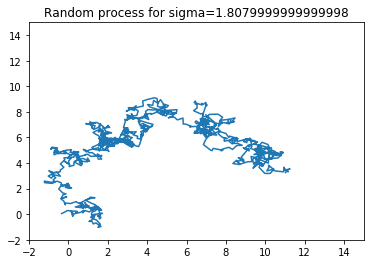

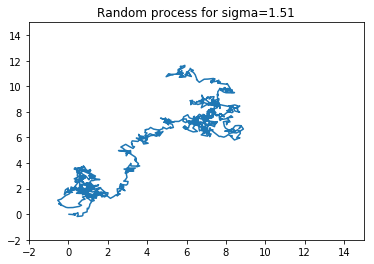

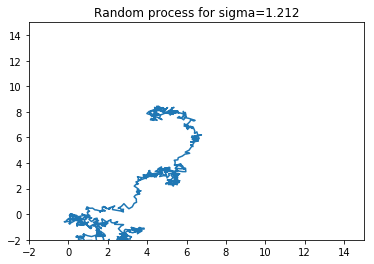

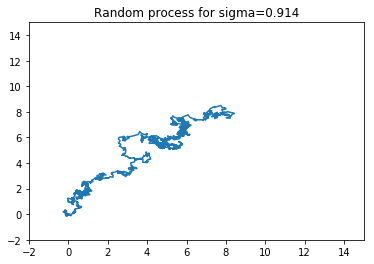

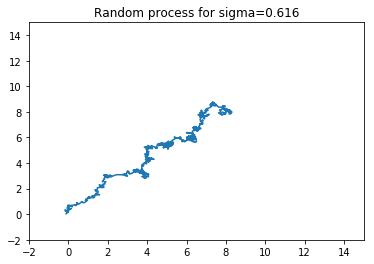

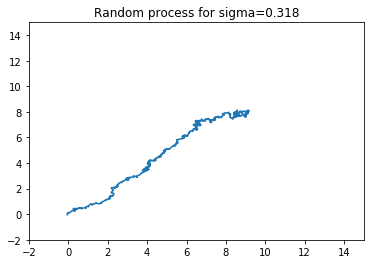

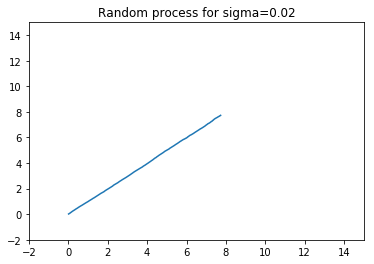

In [6]:
for _ in range(11):
    
    test_exploration.reset_state() # reset expl state to avoid correlation between rollouts
    xs, ys = [], []
    for i in range(1000):
        x, y = test_exploration.sample().tolist()
        xs.append(x)
        ys.append(y)
    sigma=test_exploration.sigma.value(test_exploration.global_step)
    plt.plot(xs, ys)
    plt.xlim(-2, 15)
    plt.ylim(-2, 15)
    plt.title(f"Random process for sigma={sigma}")
    plt.show()

    test_exploration.schedules_step()

# Define Schedules for Training:

Our DDPG actor will not learn for the first 10k iterations. (Told to actor by passing 0 learning rate for the first 10k iterations)

And it will also conduct maximum exploration during that phase to collect initial random training data. 

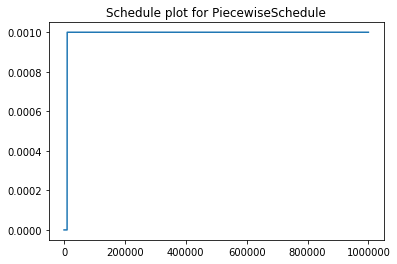

In [7]:
# Creating schedules:
# first 10000 iterations no learning - just data collection
policy_lr = PiecewiseSchedule({0: 10000}, 1e-3)
critic_lr = PiecewiseSchedule({0: 10000}, 1e-3)
policy_lr.plot(int(1e6))

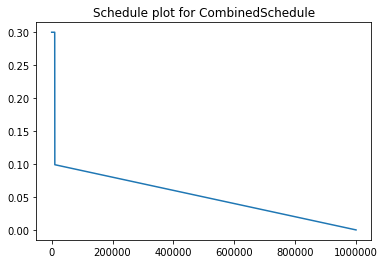

In [8]:
schedule1 = PiecewiseSchedule({0.3: 10000}, 0.0)
schedule2 = LinearSchedule(0.1, 0, 1000000)
sigma_schedule = CombinedSchedule(schedule1, schedule2, max)
sigma_schedule.plot(int(1e6))

# Create training and eval environments

In [21]:
env_name = 'InvertedPendulum-v2'
env = gym.make(env_name)
eval_env = gym.make(env_name)
eval_env.seed(np.random.randint(100))

[72]

In [22]:
env.action_space, env.action_space.high, env.action_space.low

(Box(1,), array([3.], dtype=float32), array([-3.], dtype=float32))

In [23]:
env.observation_space

Box(4,)

In [24]:
acs_dim = 1
obs_dim = 4

# Define exploration

In [25]:
# Create Annealed Ornstein-Uhlenbeck exploration:
exploration = OrnsteinUhlenbeck(
    theta=0.15,
    mu=0.,
    sigma=sigma_schedule,
    dt=1e-3,
    x0=None,
    dim=acs_dim
)

# Define DDPG actor:


In [26]:
actor = DDPG(
    device=torch.device('cuda'),
    mu_net=DeterministicMLP(obs_dim, acs_dim, out_activation=torch.nn.Tanh()),
    learning_rate=policy_lr,
    batch_size=100,
    tau=1e-3,
    n_steps_per_update=1,
    update_freq=1,
    target_updates_freq=1,
    exploration=exploration
)

# Define CDQN critic:

In [27]:
critic = CDQN(
    critic_net=ContQMLP(obs_dim, acs_dim),
    device=torch.device('cuda'),
    learning_rate=critic_lr,
    gamma=0.99,
    tau=1e-3,
    weight_decay=1e-4
)

# Provide actor with critic:

!Note: Unlike A2C or PPO/TRPO + GAE architectures DDPG updates actor and critic on the same batch of data, so critic is updated implicitly inside actor's update() method. Still, CDQN critic has its own update() method which is created to step schedules and follow the general API

In [28]:
actor.set_critic(critic)

# Create replay buffer and wrap envs into Sampler:

In [29]:
sampler = Sampler(env=env)
eval_sampler = Sampler(env=eval_env)


replay_buffer = ReplayBuffer(int(1e+6))

# Visualize untrained actor

In [30]:
visualize_actor(env=eval_env, actor=actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 34.0
Loading video...


# Run Training and Validation loop:

In [34]:
log_every = 10000
n_steps = 100000 # Enough for InvertedPendulum-v2, for other MuJoCo envs use 1000000!!!
logdir = '/home/nikita/Desktop/RelaxExamples/DDPG/tensorboard_logs'
run_name = 'ddpg_inv_pendulum'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')

for step in tqdm(range(n_steps)): # 
    
    # sample training batch
    unit_pathlist = sampler.sample(actor=actor,
                                   n_transitions=1,
                                   max_path_length=None, 
                                   reset_when_not_done=False,
                                   train_sampling=True)
    # policy.set_device(torch.device('cuda'))
    
    # add transitions to replay buffer
    replay_buffer.add_paths(unit_pathlist)
    
    # update critic
    critic_logs = critic.update(replay_buffer)
        
    # update actor
    actor_logs = actor.update(replay_buffer)
    
    if step % log_every == 0 and step > 0:
        
        # create logs of buffer
        buffer_logs = replay_buffer.create_logs(prefix='buffer')
        
        # evaluating the policy
        eval_batch = eval_sampler.sample_n_episodes(actor=actor,
                                                    n_episodes=5,
                                                    max_path_length=None, 
                                                    train_sampling=False)
        eval_logs = eval_batch.create_logs(prefix='eval')
        logs = {**critic_logs,
                **actor_logs,
                **buffer_logs,
                **eval_logs}
        
        for key, value in logs.items():
            logger.add_scalar(key, value, step)
    
logger.flush()

100%|██████████| 100000/100000 [16:39<00:00, 100.09it/s]


In [32]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/DDPG/tensorboard_logs

# Visualize trained actor

In [53]:
visualize_actor(env=eval_env, actor=actor, nsteps=100, train_sampling=False)

Simulation done, total reward: 100.0
Loading video...


# Save Models

In [68]:
actor.save_checkpoint('trained_models', 'ddpg_actor')
critic.save_checkpoint('trained_models', 'ddpg_critic')

Saved checkpoints for DDPG...
models_state_dict exploration_global_step global_step local_step n_updates n_target_updates optimizer scheduler
Saved checkpoints for CDQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler


/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Load Models

In [ ]:
policy.load_checkpoint('trained_models', 'ddpg_policy')
critic.load_checkpoint('trained_models', 'ddpg_critic')